# 1. Setup

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
from skimage import io
import copy
from PIL import Image

# Interactive mode
plt.ion()   

In [3]:
torch.cuda.device_count()

4

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

# 2. Definicja architektury i wag

In [6]:
resnet18 = models.resnet18(pretrained=True)

Po warstwach konwolucyjnych, mam ostatnie 2 warstwy:
- `(avgpool): AvgPool2d(kernel_size=7, stride=1, padding=0)`
- `(fc): Linear(in_features=512, out_features=1000, bias=True)`

Zostają one ostatecznie wycięte.

In [7]:
modified_resnet18 = nn.Sequential(*list(resnet18.children())[:-2])

Sprawdzanie czy wagi modelu po modyfikacji zostały zachowane:

In [8]:
list(resnet18.parameters())[:-2] == list(modified_resnet18.parameters())

True

### (Test) Zaladownanie wag innym sposobem

In [9]:
test_resnet18 = models.resnet18()
test_resnet18.load_state_dict(torch.load('/home/reflex/tmp/resnet18-5c106cde.pth'))

Czy modele są identyczne?

In [10]:
tensor_eq = []
for param1, param2 in zip(test_resnet18.parameters(), resnet18.parameters()):
    tensor_eq.append(float(param1.sum()) == float(param2.sum()))
    
all(tensor_eq)

True

### (Test) Ładowanie wag, wygenerowanych z uzyciem fast.ai

In [11]:
fastai_model_path = '/home/reflex/refleX/results/fastai_experiments/first_search_overview/models/best_resnet34_imgsize512_batch8_unfreeze.h5'
fastai_resnet34 = models.resnet34()
fastai_resnet34.load_state_dict(torch.load(fastai_model_path), strict=False)

# 3. Definicja architekury łączącej klasyfikatory

In [12]:
modified_resnet18_1 = nn.Sequential(*list(resnet18.children())[:-2])
modified_resnet18_2 = nn.Sequential(*list(resnet18.children())[:-2])

In [13]:
modified_resnet18_1 == modified_resnet18_2

False

In [14]:
#modified_resnet18_1.load_state_dict(torch.load(fastai_model_path), strict=False)
#modified_resnet18_2.load_state_dict(torch.load(fastai_model_path), strict=False)

Wylaczenie gradientu

In [15]:
for param in modified_resnet18_1.parameters():
    param.requires_grad = False
    
for param in modified_resnet18_2.parameters():
    param.requires_grad = False

Sieć przyjmuje 2 niezależne obiekty przycietej sieci ResNet, łączy wyniki w jeden wektor, przepuszcza to przez warstwę FC, która na wyjściu generuje 7 wyników.

In [16]:
class refleXNet(nn.Module):
    def __init__(self):
        super(refleXNet, self).__init__()
        
        self.vector_size = 1687
        self.resnet_output_size = 512
        
        self.resnet_1 = modified_resnet18_1
        self.resnet_2 = modified_resnet18_2
        self.maxpooling = nn.AdaptiveMaxPool2d((1, 1))
        
        output_vector_size = 2 * self.resnet_output_size + self.vector_size
        self.fc_1 = nn.Linear(in_features=output_vector_size, out_features=7)
        
    def forward(self, x, y, v):
        x_1 = self.resnet_1(x)
        x_2 = self.resnet_2(y)
        x = torch.cat((x_1, x_2), 1) 
        x = self.maxpooling(x)
        x = x.view(x.size(0), -1)
        
        x = torch.cat((x, v), 1) 
        x = self.fc_1(x)
        
        return x

# 4. Definicja ładowania danych (datasetu)

In [17]:
class refleXDataset(Dataset):

    def __init__(self, csv_file, root_dir, original_imgs_dir, polar_imgs_dir, vectors_dir, transform=None):
        
        # Plik CSV -> Mapowanie: obraz -> anomalie
        self.csv = pd.read_csv(csv_file)
        
        # Klasy
        self.classes = list(self.csv)[1:]
        
        # Lokalizacja obrazow
        self.root_dir = root_dir 
        self.original_imgs_dir = original_imgs_dir
        self.polar_imgs_dir = polar_imgs_dir
        self.vectors_dir = vectors_dir
        
        # Transformacja danych wejsciowych
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
                
        img_name = self.csv.iloc[idx, 0]
        original_img_path = os.path.join(self.root_dir, self.original_imgs_dir, img_name)
        polar_img_path = os.path.join(self.root_dir, self.polar_imgs_dir, img_name)
        vector_path = os.path.join(self.root_dir, self.vectors_dir, img_name)
        
        original_img = Image.open(original_img_path + ".png").convert("RGB")
        polar_img = Image.open(polar_img_path + ".png").convert("RGB")
        
        # TODO: Wiecej wektorow!
        vector = None
        
        try:
            vector = Image.open(vector_path + ".png").convert("L").getdata()
        except:
            print("[WARNING] Missing vector: %s" % img_name)
            vector = np.zeros(1687)
        
        vector_as_tensor = torch.from_numpy(np.array(vector, dtype=np.float32) / 255).float()
        
        labels = self.csv.iloc[idx, 1:].values
        labels = labels.astype('float').reshape(-1)

        if self.transform:
            original_img = self.transform(original_img)
            polar_img = self.transform(polar_img)
            
        output = [img_name, original_img, polar_img, vector_as_tensor, labels]

        return output

# 5. Łącznie wszystkich elementów w całość

## 5.1 Dataset loader

Co do transformacji, autor przykładu używa dodatkowo:
- `transforms.RandomResizedCrop(224)` (augumentacja)
- `transforms.RandomHorizontalFlip()` (augumentacja)


- **`transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])` (normalizacja - potrzebna ? # TODO!)**
    

In [18]:
stages = ['train', 'test', 'validate']

csvs = {stage: os.path.join('/home/reflex/refleX/metadata/csv', stage + '.csv') for stage in stages}

root_data_dir = '/home/reflex/refleX/metadata/labeled'
original_imgs_dir = 'original512'
polar_imgs_dir = 'polar512'
vectors_dir = 'copy_vectors'

In [ ]:
csvs

{'train': '/home/reflex/refleX/metadata/csv/train.csv',
 'test': '/home/reflex/refleX/metadata/csv/test.csv',
 'validate': '/home/reflex/refleX/metadata/csv/validate.csv'}

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validate': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
image_datasets = {stage: refleXDataset(csvs[stage], root_data_dir, original_imgs_dir, polar_imgs_dir, vectors_dir, data_transforms[stage]) for stage in stages}
dataloaders = {stage: torch.utils.data.DataLoader(image_datasets[stage], batch_size=4, shuffle=True, num_workers=4) for stage in stages}

In [ ]:
dataset_sizes = {stage: len(image_datasets[stage]) for stage in stages}
class_names = image_datasets['train'].classes
class_names

['loop_scattering',
 'background_ring',
 'strong_background',
 'diffuse_scattering',
 'artifact',
 'ice_ring',
 'non_uniform_detector']

In [ ]:
img_name, original_imgs, polar_imgs, vectors, labels = next(iter(dataloaders[stages[0]]))
original_imgs = torchvision.utils.make_grid(original_imgs)
polar_imgs = torchvision.utils.make_grid(polar_imgs)

[WARNING] Missing vector: 9N_32.0001
[WARNING] Missing vector: 7797_1_001
[WARNING] Missing vector: 25c22p3_1_E2_001


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.permute(1, 2, 0).numpy()
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    
    plt.figure(figsize=(15, 15))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

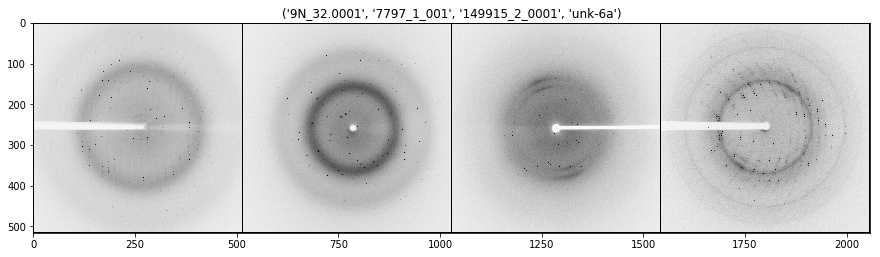

In [ ]:
imshow(original_imgs, title=img_name)

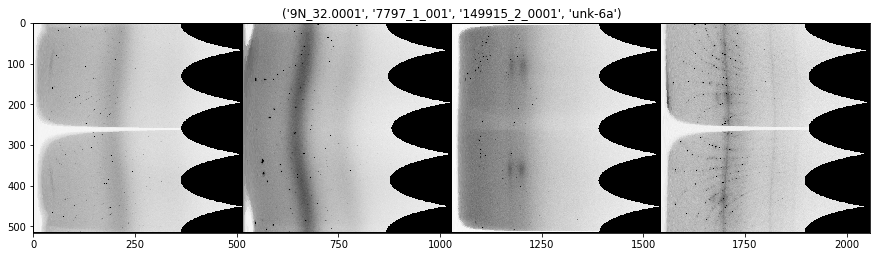

In [ ]:
imshow(polar_imgs, title=img_name)

In [ ]:
for img, lab in zip(img_name, labels):
    print(img, lab)

9N_32.0001 tensor([1., 1., 1., 0., 0., 0., 0.], device='cpu', dtype=torch.float64)
7797_1_001 tensor([0., 1., 1., 0., 0., 0., 0.], device='cpu', dtype=torch.float64)
149915_2_0001 tensor([1., 1., 1., 0., 0., 0., 1.], device='cpu', dtype=torch.float64)
unk-6a tensor([1., 0., 0., 1., 0., 1., 0.], device='cpu', dtype=torch.float64)


### Parametry i loss

In [ ]:
# Net
model = refleXNet()
_ = model.to(device)

In [ ]:
# Loss
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validate']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for _, orignal_img, polar_img, vectors, labels in dataloaders[phase]:
                orignal_img = orignal_img.to(device)
                polar_img = polar_img.to(device)
                vectors = vectors.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(orignal_img, polar_img, vectors)
                    labels = labels.float()
                    
                    # Klasyfikacja wieloetykietowa !
                    # _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * orignal_img.size(0)
            
                # Ma sens?
                threshold = 0 
                preds = (outputs > threshold).float()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validate' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
best_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=24)

Epoch 0/23
----------
[WARNING] Missing vector: 1548_M4_D3_data.0001
[WARNING] Missing vector: 7162_3_001
[WARNING] Missing vector: 21c10p2_2_E2_001
[WARNING] Missing vector: 3h0p_stm1194_n1_nat_2
[WARNING] Missing vector: 17c10p4_3_001
[WARNING] Missing vector: 13c50p1_1_001
[WARNING] Missing vector: 1001_M2_B7_low.0001
[WARNING] Missing vector: 1732-m1d7g-peak.0001
[WARNING] Missing vector: 11c12p3_1_E2_091
[WARNING] Missing vector: 16-m2b3g-peak.0001
[WARNING] Missing vector: 2204_M2_E5_peak.0001
[WARNING] Missing vector: 21c1p1_1_E2_001
[WARNING] Missing vector: 13Feb15_n1_collect_sweep2_0001
[WARNING] Missing vector: 7275_3_001
[WARNING] Missing vector: 2997_3_001
[WARNING] Missing vector: 23c28p2_2_001
[WARNING] Missing vector: 8646_1_001
[WARNING] Missing vector: 25c22p3_1_E2_001
[WARNING] Missing vector: 778_M1_F4_low.0001
[WARNING] Missing vector: 114_M2_A4_high.0001
[WARNING] Missing vector: 7275_2_001
[WARNING] Missing vector: 17c2p3_4_001
[WARNING] Missing vector: 3ga7_stm4

---

___

---

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs, inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)